In [1]:
import pandas as pd
from igraph import Graph
import igraph as ig

def create_graph(gender, type_, subfix):
    adj_path = f'Data\\3.AdjacencyMatrices\\Adj_Matrix_{gender}_{type_}_{subfix}.csv'
    A = pd.read_csv(adj_path, sep=' ', header=None)
    
    if type_ == 'ICD':
        type_ = 'ICD10_Diagnoses'
    names_path = f'Comorbidity-Networks-From-Population-Wide-Health-Data-main\\{type_}_All.csv'
    df_names = pd.read_csv(names_path)#, index_col=0)
    
    if A.shape[0] != df_names.shape[0]:
        raise ValueError("Adjacency matrix size and names dataframe size do not match!")
    
    # Create graph from adjacency matrix
    # igraph expects edges as a list of tuples and weights as a separate list
    
    edges = []
    weights = []
    n = A.shape[0]
    for i in range(n):
        for j in range(n):
            w = A.iat[i, j]
            if w != 0:
                edges.append((i, j))
                weights.append(w)
    
    g = Graph(edges=edges, directed=False)  # or directed=True if your network is directed
    g.es['weight'] = weights
    
    # Add node attributes
    g.vs['id'] = df_names.index.tolist()
    
    if type_ == 'Chronic':
        name_col = 'label'
    elif type_ == 'ICD10_Diagnoses':
        name_col = 'icd_code'
    elif type_ == 'Block':
        name_col = 'block_name'
    else:
        raise ValueError(f"Unknown type: {type_}")
    
    g.vs['name'] = df_names[name_col].tolist()
    
    if type_ == 'ICD10_Diagnoses':
        # g.vs['description'] = df_names['descr'].tolist()
        icd_eng = pd.read_csv('Comorbidity-Networks-From-Population-Wide-Health-Data-main\\ICD10_Diagnoses_All_ENG.csv')
        #map descrpition to icd code
        icd_dict = icd_eng.set_index('Code')['ShortDescription'].to_dict()
        g.vs['description'] = [icd_dict.get(code, '') for code in g.vs['name']]
        
    if type_ == 'ICD10_Diagnoses' and 'age' in subfix:
        df_prev = pd.read_csv(f'Data\\1.Prevalence\\Prevalence_Sex_Age_Year_ICD.csv')
        age_dict = {'age_1': '0-9', 'age_2': '10-19', 'age_3': '20-29', 
                    'age_4': '30-39', 'age_5': '40-49', 'age_6': '50-59', 
                    'age_7': '60-69', 'age_8': '70-79', 'age_9': '80+'}
        age_col = age_dict[subfix]
        df_prev = df_prev[(df_prev['Age_Group'] == age_col) & (df_prev['sex'] == gender)]
        
        #assign to each icd code its prevalence
        prevalence_dict = df_prev.set_index('icd_code')['p'].to_dict()
        g.vs['prevalence'] = [prevalence_dict.get(code, 0) for code in g.vs['name']]
    
    return g

In [2]:
graphs = {}
for sex in ['Male', 'Female']:
    for age_id in ['1', '2', '3', '4', '5', '6', '7', '8']:
        print('Processing ', sex, ' age group ', age_id)
        g = create_graph(sex, 'ICD', f'age_{age_id}')
        graphs[sex + '_age_' + age_id] = g

Processing  Male  age group  1
Processing  Male  age group  2
Processing  Male  age group  3
Processing  Male  age group  4
Processing  Male  age group  5
Processing  Male  age group  6
Processing  Male  age group  7
Processing  Male  age group  8
Processing  Female  age group  1
Processing  Female  age group  2
Processing  Female  age group  3
Processing  Female  age group  4
Processing  Female  age group  5
Processing  Female  age group  6
Processing  Female  age group  7
Processing  Female  age group  8


In [130]:
for name, g in graphs.items():
    ig.write(g, f'Data\\4.Graphs-gexffiles\\ICD_'+ name + '.gml', format='gml')

In [14]:
import leidenalg

def community_detection(g):
    # Trim zero degree vertices
    g.delete_vertices(g.vs.select(_degree=0))
    
    # Perform community detection using Leiden algorithm
    partition = leidenalg.find_partition(
        g,
        leidenalg.RBConfigurationVertexPartition,
        weights='weight',
        # resolution_parameter=0.01  # try values 0.01 – 1.0
    )
    
    # Get community labels per node
    community_labels = partition.membership  # List aligned with g.vs
    
    # Assign community labels to the graph vertices
    g.vs['community'] = community_labels

In [16]:
for name, g in graphs.items():
    print('Processing community detection for ', name)
    community_detection(g)
    # Save the graph with communities
    ig.write(g, f'Data\\4.Graphs-gexffiles\\ICD_{name}_communities.gml', format='gml')

Processing community detection for  Male_age_1
Processing community detection for  Male_age_2
Processing community detection for  Male_age_3
Processing community detection for  Male_age_4
Processing community detection for  Male_age_5
Processing community detection for  Male_age_6
Processing community detection for  Male_age_7
Processing community detection for  Male_age_8
Processing community detection for  Female_age_1
Processing community detection for  Female_age_2
Processing community detection for  Female_age_3
Processing community detection for  Female_age_4
Processing community detection for  Female_age_5
Processing community detection for  Female_age_6
Processing community detection for  Female_age_7
Processing community detection for  Female_age_8


In [ ]:
import numpy as np
from scipy.optimize import linear_sum_assignment
from collections import defaultdict

def jaccard_overlap(set1, set2):
    return len(set1 & set2) / len(set1 | set2) if set1 | set2 else 0

def build_community_sets(label_dict):
    community_sets = defaultdict(set)
    for node, label in label_dict.items():
        community_sets[label].add(node)
    return community_sets

def align_labels_jaccard(prev_labels, curr_labels):
    prev_sets = build_community_sets(prev_labels)
    curr_sets = build_community_sets(curr_labels)

    prev_list = list(prev_sets.items())
    curr_list = list(curr_sets.items())

    sim_matrix = [[jaccard_overlap(curr[1], prev[1]) for prev in prev_list] for curr in curr_list]
    sim_matrix = -1 * np.array(sim_matrix)  # Hungarian algorithm minimizes cost

    row_ind, col_ind = linear_sum_assignment(sim_matrix)
    mapping = {}

    used_labels = set(prev_labels.values())
    next_label = max(used_labels, default=-1) + 1

    for r, c in zip(row_ind, col_ind):
        if -sim_matrix[r, c] > 0:  # Only map if overlap > 0
            mapping[curr_list[r][0]] = prev_list[c][0]

    # Assign new labels to unmatched
    unmatched = set(curr_sets.keys()) - set(mapping.keys())
    for u in unmatched:
        mapping[u] = next_label
        next_label += 1

    aligned = {node: mapping[label] for node, label in curr_labels.items()}
    return aligned

def align_using_biggest_reference(graphs_dict, sex_keyword='Male', attr='community'):
    # Step 1: Filter by sex
    filtered = {k: g for k, g in graphs_dict.items() if sex_keyword in k}
    
    # Step 2: Find keys containing '8' to use as references
    ref_keys = [k for k in filtered if '8' in k]
    if not ref_keys:
        raise ValueError(f"No reference graphs with '8' in key found for sex {sex_keyword}!")

    # Sort ref keys to choose a single reference graph (e.g. the first one)
    ref_key = sorted(ref_keys)[0]
    ref_graph = filtered[ref_key]
    ref_labels = {v['name']: v[attr] for v in ref_graph.vs}

    aligned_labels_by_key = {}
    aligned_labels_by_key[ref_key] = ref_labels

    # Step 3: Align all other graphs to the reference
    for key, g in filtered.items():
        if key == ref_key:
            continue
        curr_labels = {v['name']: v[attr] for v in g.vs}
        aligned = align_labels_jaccard(ref_labels, curr_labels)

        # Assign aligned labels back to graph vertices
        for v in g.vs:
            v['aligned_community'] = aligned[v['name']]

        aligned_labels_by_key[key] = aligned

    # Also set aligned labels in reference graph for consistency
    for v in ref_graph.vs:
        v['aligned_community'] = ref_labels[v['name']]

    return aligned_labels_by_key

In [37]:
male_aligned = align_using_biggest_reference(graphs, 'Male', 'community')
female_aligned = align_using_biggest_reference(graphs, 'Female', 'community')

In [38]:
for name, g in graphs.items():
    ig.write(g, f'Data\\4.Graphs-gexffiles\\ICD_{name}_communities.gml', format='gml')

In [85]:
def find_community_bridges(g, community_attr='community'):
    bridge_nodes = []

    for v in g.vs:
        this_comm = v[community_attr]
        neighbor_comms = set(g.vs[n][community_attr] for n in g.neighbors(v))

        # Check if the node connects to at least one other community
        if len(neighbor_comms - {this_comm}) >= 0:
            bridge_nodes.append({
                'ICD_Code': v['name'],
                'Community': this_comm,
                'Bridges_To': list(neighbor_comms - {this_comm}),
                'Num_Connections': len(neighbor_comms - {this_comm}),
                'Mortality': v['mortality']
            })

    return pd.DataFrame(bridge_nodes)

In [90]:
dfs = []
for name, g in graphs.items():
    bridges_df = find_community_bridges(g, community_attr='aligned_community')
    dfs.append(bridges_df.assign(Graph=name))

# Combine all dataframes into one
df_bridges = pd.concat(dfs, ignore_index=True)
#move last column to first
df_bridges = df_bridges[['Graph', 'ICD_Code', 'Community',  'Num_Connections', 'Bridges_To', 'Mortality']]
#sort ny graph
df_bridges = df_bridges.sort_values(by='Graph').reset_index(drop=True)
df_bridges[['Sex', 'Age_ID']] = df_bridges['Graph'].str.extract(r'^(Male|Female).*?(\d+)$')
df_bridges = df_bridges[['Sex', 'Age_ID','ICD_Code', 'Community',  'Num_Connections', 'Bridges_To', 'Mortality']]
df_bridges

,Sex,Age_ID,ICD_Code,Community,Num_Connections,Bridges_To,Mortality
0,Female,1,A02,16,0,[],0.000000
1,Female,1,J96,11,3,"[16, 0, 7]",0.136456
2,Female,1,J90,0,0,[],0.045045
3,Female,1,J46,0,0,[],0.002809
4,Female,1,J45,0,0,[],0.019600
...,...,...,...,...,...,...,...
3926,Male,8,G30,6,1,[0],0.082747
3927,Male,8,G25,0,1,[2],0.003452
3928,Male,8,G21,0,1,[6],0.107769
3929,Male,8,G63,0,0,[],0.063260


In [97]:
grouped_mortality = (
    df_bridges
    .groupby(['Sex', 'Age_ID', 'Community'])['Mortality']
    .mean()
    .reset_index()
)

,Sex,Age_ID,Community,Mortality
0,Female,1,0,0.028063
1,Female,1,1,0.055755
2,Female,1,3,0.000293
3,Female,1,5,0.071765
4,Female,1,7,0.064063
...,...,...,...,...
274,Male,8,3,0.004778
275,Male,8,4,0.048261
276,Male,8,5,0.176511
277,Male,8,6,0.041373


In [100]:
def map_comm_mortality(row):
    communities = row['Bridges_To']
    mor = []
    for c in communities:
        mortality = grouped_mortality[grouped_mortality['Community'] == c]['Mortality'].values[0]
        mor.append(mortality)
    
    return mor

df_bridges['Bridges_Mortality'] = df_bridges.apply(map_comm_mortality, axis=1)
df_bridges

,Sex,Age_ID,ICD_Code,Community,Num_Connections,Bridges_To,Mortality,Bridges_Mortality
0,Female,1,A02,16,0,[],0.000000,[]
1,Female,1,J96,11,3,"[16, 0, 7]",0.136456,"[0.03657605267282186, 0.028063329008365948, 0...."
2,Female,1,J90,0,0,[],0.045045,[]
3,Female,1,J46,0,0,[],0.002809,[]
4,Female,1,J45,0,0,[],0.019600,[]
...,...,...,...,...,...,...,...,...
3926,Male,8,G30,6,1,[0],0.082747,[0.028063329008365948]
3927,Male,8,G25,0,1,[2],0.003452,[0.025442716698723566]
3928,Male,8,G21,0,1,[6],0.107769,[0.0]
3929,Male,8,G63,0,0,[],0.063260,[]


In [101]:
df_bridges.to_csv('ICD_Bridges.csv', index=False)

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_top_icd_connections_by_sex(df_bridges, top_n=10, figsize=(14, 5)):
    df = df_bridges.copy()

    # Identify sex from 'Graph' column
    df['Sex'] = df['Graph'].apply(lambda x: 'Male' if 'Male' in x else ('Female' if 'Female' in x else 'Unknown'))

    fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=True)

    for i, sex in enumerate(['Male', 'Female']):
        df_sex = df[df['Sex'] == sex]

        # Sort Graphs by appearance order
        sorted_graphs = sorted(df_sex['Graph'].unique())
        df_sex['Graph'] = pd.Categorical(df_sex['Graph'], categories=sorted_graphs, ordered=True)

        # Get top ICD codes by total connections in this sex group
        top_icds = (
            df_sex.groupby('ICD_Code')['Num_Connections']
            .sum()
            .nlargest(top_n)
            .index
        )
        df_top = df_sex[df_sex['ICD_Code'].isin(top_icds)]

        # Pivot for plotting
        pivot_df = df_top.pivot_table(index='Graph', columns='ICD_Code', values='Num_Connections', fill_value=0)

        # Plot
        sns.lineplot(data=pivot_df, ax=axes[i])
        axes[i].set_title(f"{sex} - Top {top_n} ICD Codes by Bridge Connections")
        axes[i].set_xlabel("Graph (Age Group / Time)")
        axes[i].tick_params(axis='x', rotation=45)
        if i == 0:
            axes[i].set_ylabel("Number of Connections")
        else:
            axes[i].set_ylabel("")

        axes[i].legend(title='ICD Code', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

C:\Users\Giovanni Palermo\AppData\Local\Temp\ipykernel_2732\1323950111.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sex['Graph'] = pd.Categorical(df_sex['Graph'], categories=sorted_graphs, ordered=True)
C:\Users\Giovanni Palermo\AppData\Local\Temp\ipykernel_2732\1323950111.py:30: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_df = df_top.pivot_table(index='Graph', columns='ICD_Code', values='Num_Connections', fill_value=0)
C:\Users\Giovanni Palermo\AppData\Local\Temp\ipykernel_2732\1323950111.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

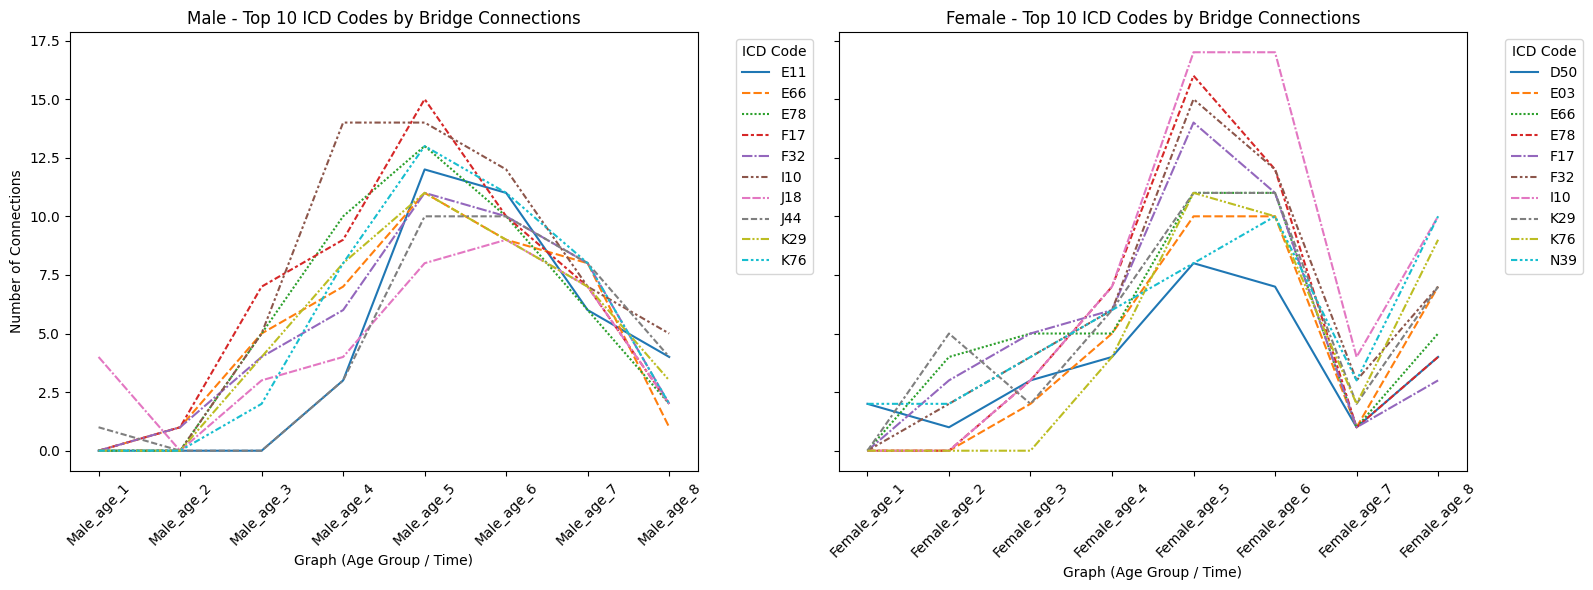

In [46]:
plot_top_icd_connections_by_sex(df_bridges, top_n=10, figsize=(16, 6))

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

def plot_centrality_vs_bridges(graphs, df_bridges, max_cols=4, figsize=(16, 12)):
    # Prepare bridge data
    bridge_counts = df_bridges[['Graph', 'ICD_Code', 'Num_Connections']].copy()
    bridge_counts = bridge_counts.rename(columns={'ICD_Code': 'name'})  # for merge

    # Sort graphs for reproducibility
    sorted_keys = sorted(graphs.keys())
    n_graphs = len(sorted_keys)
    n_cols = min(max_cols, n_graphs)
    n_rows = int(np.ceil(n_graphs / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, squeeze=False)

    for idx, key in enumerate(sorted_keys):
        g = graphs[key]
        ax = axes[idx // n_cols, idx % n_cols]

        # Get betweenness centrality (as dict: name -> centrality)
        bw_values = g.betweenness()
        bw_df = pd.DataFrame({'name': g.vs['name'], 'Betweenness': bw_values})

        # Merge with bridge counts
        bridge_df = bridge_counts[bridge_counts['Graph'] == key]
        merged = pd.merge(bw_df, bridge_df, on='name', how='left')
        merged['Num_Connections'] = merged['Num_Connections'].fillna(0)
        
                # Compute Pearson correlation
        if merged['Betweenness'].std() > 0 and merged['Num_Connections'].std() > 0:
            corr, pval = pearsonr(merged['Betweenness'], merged['Num_Connections'])
            corr_text = f"r = {corr:.2f}"
        else:
            corr_text = "r = n/a"
        
        color = 'blue' if 'Male' in key else 'red'

        # Scatter plot
        ax.scatter(
            merged['Betweenness'],
            merged['Num_Connections'],
            alpha=0.6,
            color=color,
        )
        ax.set_title(f"{key} ({corr_text})")
        ax.set_xlabel("Betweenness Centrality")
        ax.set_ylabel("Num. Community Bridges")
        ax.set_xscale('log')

    # Hide unused axes
    for idx in range(n_graphs, n_rows * n_cols):
        axes[idx // n_cols, idx % n_cols].axis('off')

    plt.tight_layout()
    plt.show()


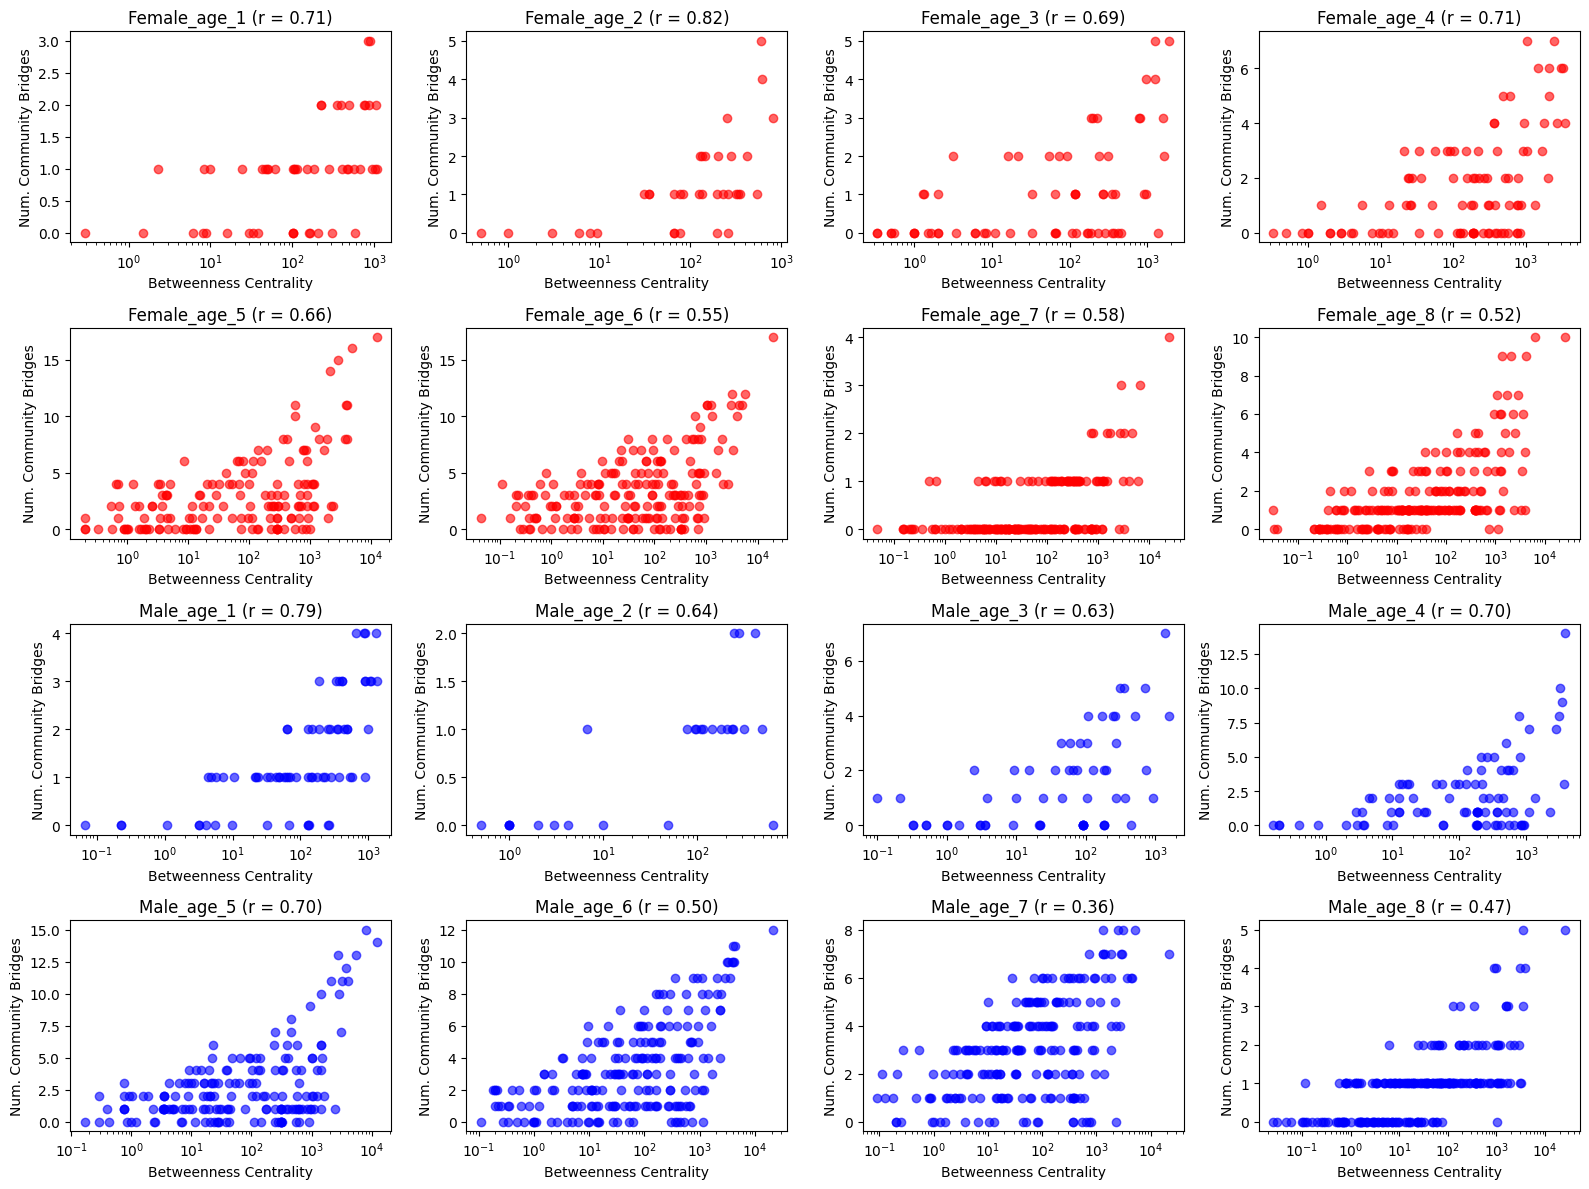

In [65]:
plot_centrality_vs_bridges(graphs, df_bridges)

In [68]:
df1 = pd.read_csv('mortality_diag_Male.csv')
df2 = pd.read_csv('mortality_diag_Female.csv')
df1

,pri_diag_id,age_10,n_pats,n_mortality,mortality,icd_code
0,2,6,8,NaN,0.000000,A01
1,2,7,10,NaN,0.000000,A01
2,2,8,9,NaN,0.000000,A01
3,2,3,19,NaN,0.000000,A01
4,2,1,39,NaN,0.000000,A01
...,...,...,...,...,...,...
8098,1682,4,498,NaN,0.000000,K64
8099,1682,9,157,2.0,0.012739,K64
8100,1682,10,12,NaN,0.000000,K64
8101,1682,7,630,1.0,0.001587,K64


In [72]:
def assign_mortality(g, df_mortality, age_id):
    # Create a mapping from ICD code to mortality
    mortality_dict = df_mortality[df_mortality['age_10'] == age_id][['icd_code', 'mortality']].set_index('icd_code')['mortality'].to_dict()
    
    # Assign mortality to each vertex based on ICD code
    g.vs['mortality'] = [mortality_dict.get(code, 0) for code in g.vs['name']]
    
    return g

In [73]:
for sex in ['Male', 'Female']:
    for age_id in ['1', '2', '3', '4', '5', '6', '7', '8']:
        if sex == 'Male':
            df_mortality = df1
        else:
            df_mortality = df2
        g = assign_mortality(g, df_mortality, age_id)

In [131]:
for name, g in graphs.items():
    # Save the graph with communities
    ig.write(g, f'Data\\4.Graphs-gexffiles\\ICD_{name}_communities.gml', format='gml')

In [118]:
male_comm = pd.read_csv('Data\\temporal_communities_Male_ICD.csv')
fem_comm = pd.read_csv('Data\\temporal_communities_Female_ICD.csv')
icd_codes = pd.read_csv('Comorbidity-Networks-From-Population-Wide-Health-Data-main\\ICD10_Diagnoses_All.csv')
male_comm['node'] = male_comm['node'] + 1
#map icd_codes to names
icd_dict = icd_codes.set_index('diagnose_id')['icd_code'].to_dict()
male_comm['ICD_code'] = male_comm['node'].map(icd_dict)
fem_comm['ICD_code'] = fem_comm['node'].map(icd_dict)
male_comm['Sex'] = 'Male'
fem_comm['Sex'] = 'Female'
df_erik = pd.concat([male_comm, fem_comm], ignore_index=True)
df_erik.drop(columns=['node'], inplace=True)
df_erik.rename({'age': 'Age_ID', 'block': 'Communities'}, axis=1, inplace=True)
df_erik = df_erik[['Sex', 'Age_ID', 'ICD_code', 'Communities']]
df_erik.to_csv('Data\\communities_erik.csv', index=False)

In [119]:
df_erik

,Sex,Age_ID,ICD_code,Communities
0,Male,1,A00,0
1,Male,1,A01,0
2,Male,1,A02,1
3,Male,1,A03,0
4,Male,1,A04,1
...,...,...,...,...
17275,Female,8,N94,1017
17276,Female,8,N95,445
17277,Female,8,N96,445
17278,Female,8,N97,445


In [127]:
#Reassign communities based on erik's labels
for sex in ['Male', 'Female']:
    for age_id in ['1', '2', '3', '4', '5', '6', '7', '8']:
        g = graphs[sex+'_age_' + age_id]
        df_filt = df_erik[(df_erik['Sex'] == sex) & (df_erik['Age_ID'] == int(age_id))]
        # Create a mapping from ICD code to community
        community_dict = df_filt.set_index('ICD_code')['Communities'].to_dict()
        # Assign communities to each vertex based on ICD code
        g.vs['erik_community'] = [community_dict.get(code, -1) for code in g.vs['name']]

In [129]:
dfs = []
for name, g in graphs.items():
    bridges_df = find_community_bridges(g, community_attr='erik_community')
    dfs.append(bridges_df.assign(Graph=name))

# Combine all dataframes into one
df_bridges = pd.concat(dfs, ignore_index=True)
#move last column to first
df_bridges = df_bridges[['Graph', 'ICD_Code', 'Community',  'Num_Connections', 'Bridges_To', 'Mortality']]
#sort ny graph
df_bridges = df_bridges.sort_values(by='Graph').reset_index(drop=True)
df_bridges[['Sex', 'Age_ID']] = df_bridges['Graph'].str.extract(r'^(Male|Female).*?(\d+)$')
df_bridges = df_bridges[['Sex', 'Age_ID','ICD_Code', 'Community',  'Num_Connections', 'Bridges_To', 'Mortality']]
df_bridges

,Sex,Age_ID,ICD_Code,Community,Num_Connections,Bridges_To,Mortality
0,Female,1,A02,438,1,[1037],0.000000
1,Female,1,J96,1037,2,"[438, 1015]",0.136456
2,Female,1,J90,438,1,[1037],0.045045
3,Female,1,J46,438,1,[1015],0.002809
4,Female,1,J45,1015,2,"[1037, 438]",0.019600
...,...,...,...,...,...,...,...
3926,Male,8,G30,64,6,"[54, 55, 56, 60, 61, 63]",0.082747
3927,Male,8,G25,55,5,"[53, 60, 61, 62, 63]",0.003452
3928,Male,8,G21,55,5,"[64, 53, 60, 61, 63]",0.107769
3929,Male,8,G63,54,5,"[64, 53, 55, 61, 63]",0.063260


In [134]:
df_edges = pd.DataFrame(columns=['Sex', 'Age_ID', 'Edge_ID', 'ICD_Code_1', 'ICD_Code_2', 'Weight', 'Betweeness', 'Mortality_1', 'Mortality_2'])

from tqdm.auto import tqdm



for sex in ['Male', 'Female']:
    for age_id in tqdm(['1', '2', '3', '4', '5', '6', '7', '8']):
        g = graphs[sex+'_age_' + age_id]
        #drop multiple edges and keep just 1
        # g = g.simplify(multiple=True, loops=False)        
        eb = g.edge_betweenness()
        g.es['betweenness'] = eb
        for edge in g.es:
            edge_id = edge.index
            icd_code_1 = g.vs[edge.source]['name']
            icd_code_2 = g.vs[edge.target]['name']
            weight = edge['weight']
            betweenness = g.es[edge_id]['betweenness']
            mortality_1 = g.vs[edge.source]['mortality']
            mortality_2 = g.vs[edge.target]['mortality']
            new_row = {'Sex': sex, 'Age_ID': age_id, 'Edge_ID': edge_id, 
                       'ICD_Code_1': icd_code_1, 'ICD_Code_2': icd_code_2, 
                       'Weight': weight, 'Betweeness': betweenness, 
                       'Mortality_1': mortality_1, 'Mortality_2': mortality_2}
            df_edges.loc[len(df_edges)] = new_row

df_edges

  0%|          | 0/8 [00:00<?, ?it/s]

KeyError: 'Attribute does not exist'